In [1]:
import sys
import torch
import warnings
import numpy as np
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [2]:
def fetch_batch(x, y, batch_index, batch_size):
    start = batch_index*batch_size
    end = batch_index*batch_size+batch_size
    x_batch = x[start:end]
    if y is not None:
        y_batch = y[start:end]
        return x_batch, y_batch
    else:
        return x_batch

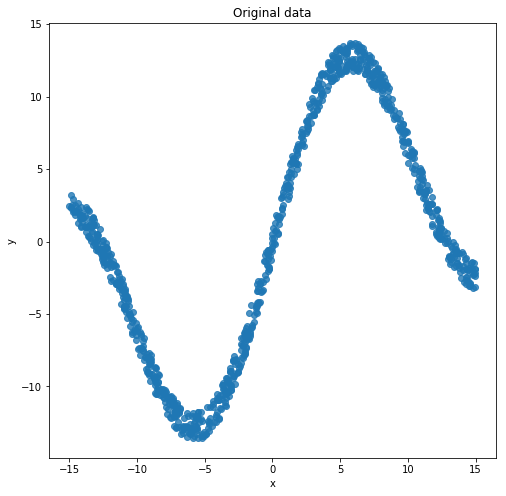

In [3]:
N = 3000
IN_DIM = 1
OUT_DIM = IN_DIM
x = np.random.uniform(-15., 15., (IN_DIM, N)).T.astype(np.float32)
noise = np.random.uniform(-1, 1, (N, IN_DIM)).astype(np.float32)
# noise = np.random.normal(size=(N, 1)).astype(np.float32)
y = 0.5*x + 10.*np.sin(0.3*x) + noise
x_train, x_test, y_train, y_test = train_test_split(x, y)

plt.figure(figsize=(8, 8))
plt.title('Original data')
ax = sns.regplot(x[:1000], y[:1000], fit_reg=False)
ax.set(xlabel='x', ylabel='y')
plt.show()

In [4]:
class Net(nn.Module):

    def __init__(self, input_dim=IN_DIM, out_dim=OUT_DIM, layer_size=20):
        super(Net, self).__init__()
        self.fc = nn.Linear(input_dim, layer_size)
        self.logit = nn.Linear(layer_size, out_dim)

    def forward(self, x):
        x = F.sigmoid(self.fc(x))
        x = self.logit(x)
        return x

net = Net()
print(net)

Net(
  (fc): Linear(in_features=1, out_features=20, bias=True)
  (logit): Linear(in_features=20, out_features=1, bias=True)
)


In [5]:
def train(net, x_train, y_train, x_test, y_test):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.1)

    N_EPOCHES = 2000
    BS = 1500
    n_batches = int(np.ceil(x_train.shape[0] / BS))
    train_losses = []
    test_losses = []
    for i in range(N_EPOCHES):
        for bi in range(n_batches):
            x_batch, y_batch = fetch_batch(x_train, y_train, bi, BS)
            x_train_var = Variable(torch.from_numpy(x_batch))
            y_train_var = Variable(torch.from_numpy(y_batch))
            optimizer.zero_grad()
            outputs = net(x_train_var)
            loss = criterion(outputs, y_train_var)
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            x_test_var = Variable(torch.from_numpy(x_test))
            y_test_var = Variable(torch.from_numpy(y_test))
            outputs = net(x_test_var)
            test_loss = criterion(outputs, y_test_var)
            test_losses.append(test_loss.item())
            train_losses.append(loss.item())
            if i%100 == 0:
                sys.stdout.write('\r Iter: %d, test loss: %.5f, train loss: %.5f'
                                 %(i, test_loss.item(), loss.item()))
                sys.stdout.flush()
    return train_losses, test_losses

train_losses, test_losses = train(net, x_train, y_train, x_test, y_test)

 Iter: 1900, test loss: 0.34994, train loss: 0.328318

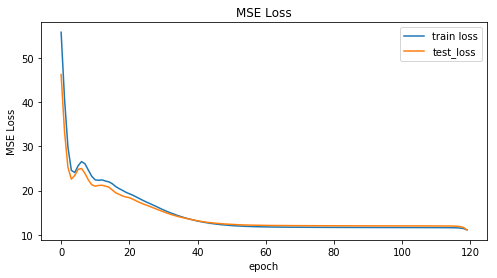

In [6]:
fig = plt.figure(figsize=(8, 4))
ax = sns.lineplot(np.arange(len(train_losses[:120])), train_losses[:120])
ax = sns.lineplot(np.arange(len(test_losses[:120])), test_losses[:120])
ax.set(xlabel='epoch', ylabel='MSE Loss')
plt.legend(['train loss', 'test_loss'])
plt.title('MSE Loss')
plt.show()

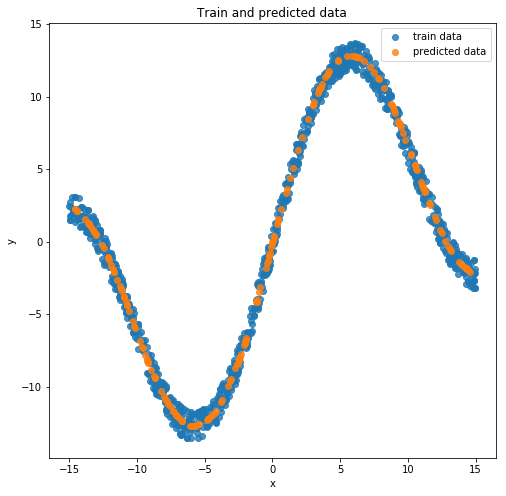

In [7]:
out = net(Variable(torch.from_numpy(x_test)))
fig = plt.figure(figsize=(8, 8))
ax = sns.regplot(x_train[:1000], y_train[:1000], fit_reg=False)
ax = sns.regplot(x_test[:200], out.data.numpy()[:200], fit_reg=False)
ax.set(xlabel='x', ylabel='y')
plt.title('Train and predicted data')
plt.legend(['train data', 'predicted data'])
plt.show()

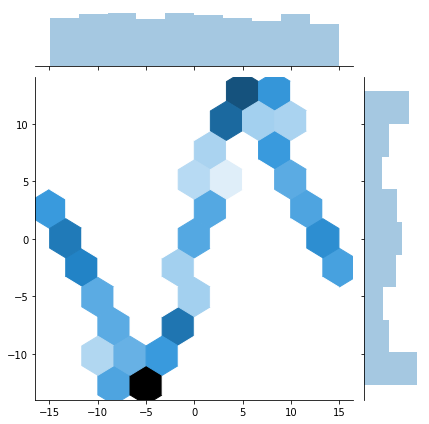

In [8]:
sns.jointplot(x_test, out.data.numpy(), kind="hex")
plt.show()

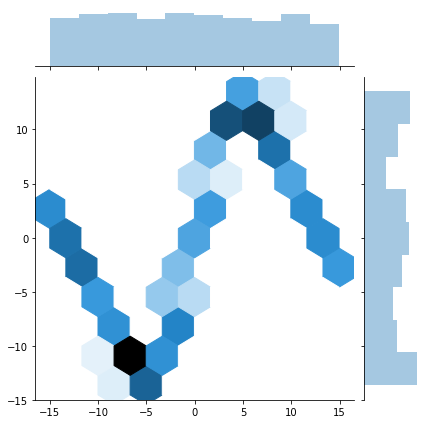

In [9]:
sns.jointplot(x_test, y_test, kind="hex")
plt.show()

<h2>Inverse problem</h2>

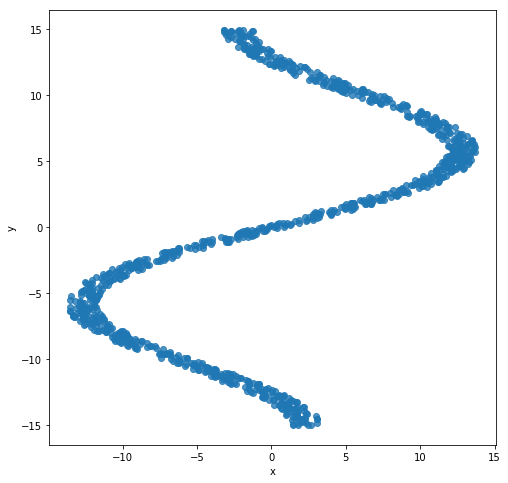

In [10]:
x_train_inv = y_train
y_train_inv = x_train
x_test_inv = y_train
y_test_inv = x_train
plt.figure(figsize=(8, 8))
ax = sns.regplot(x_train_inv[:1000], y_train_inv[:1000], fit_reg=False)
ax.set(xlabel='x', ylabel='y')
plt.show()

In [11]:
inv_train_losses, inv_test_losses = train(net, x_train_inv, y_train_inv, x_test_inv, y_test_inv)

 Iter: 1900, test loss: 45.45585, train loss: 44.46864

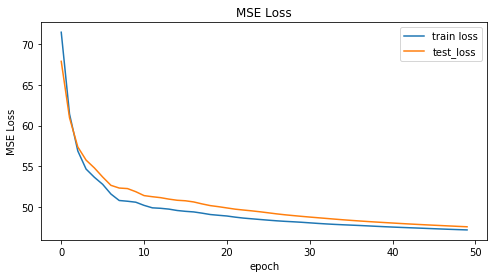

In [13]:
fig = plt.figure(figsize=(8, 4))
ax = sns.lineplot(np.arange(len(inv_train_losses[:50])), inv_train_losses[:50])
ax = sns.lineplot(np.arange(len(inv_test_losses[:50])), inv_test_losses[:50])
ax.set(xlabel='epoch', ylabel='MSE Loss')
plt.legend(['train loss', 'test_loss'])
plt.title('MSE Loss')
plt.show()

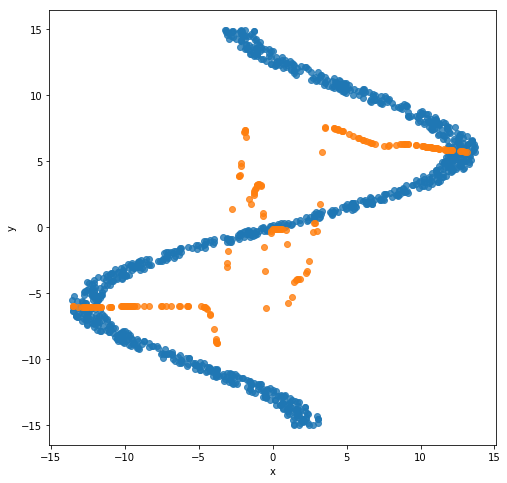

In [14]:
out = net(Variable(torch.from_numpy(x_test_inv)))
fig = plt.figure(figsize=(8, 8))
ax = sns.regplot(x_train_inv[:1000], y_train_inv[:1000], fit_reg=False)
ax = sns.regplot(x_test_inv[:200], out.data.numpy()[:200], fit_reg=False)
ax.set(xlabel='x', ylabel='y')
plt.show()

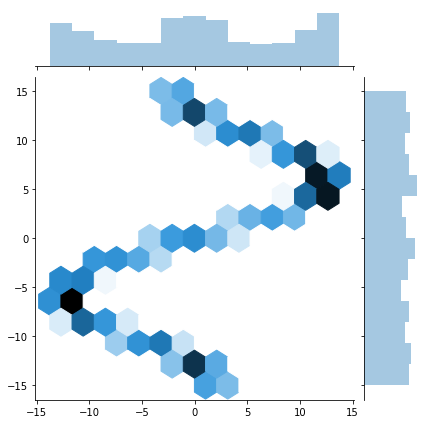

In [15]:
sns.jointplot(x_test_inv, y_test_inv, kind="hex")
plt.show()

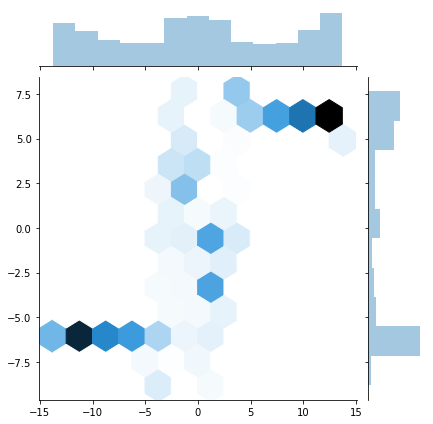

In [16]:
sns.jointplot(x_test_inv, out.data.numpy(), kind="hex")
plt.show()

<h2>Mixture density networks</h2>

In [17]:
COEFS = 30
class MDN(nn.Module):

    def __init__(self, input_dim=IN_DIM, out_dim=OUT_DIM, layer_size=50, coefs=COEFS):
        super(MDN, self).__init__()
        self.fc = nn.Linear(input_dim, layer_size)
        self.pi = nn.Linear(layer_size, coefs)
        self.mu = nn.Linear(layer_size, out_dim*coefs) # mean
        self.sigma_sq = nn.Linear(layer_size, coefs) # variance
        self.out_dim = out_dim
        self.coefs = coefs

    def forward(self, x):
        x = F.tanh(self.fc(x))
        pi = F.softmax(self.pi(x), dim=1)
        sigma_sq = torch.exp(self.sigma_sq(x))
        mu = self.mu(x)
        return pi, mu, sigma_sq
    
mdn_net = MDN()
print(mdn_net)

MDN(
  (fc): Linear(in_features=1, out_features=50, bias=True)
  (pi): Linear(in_features=50, out_features=30, bias=True)
  (mu): Linear(in_features=50, out_features=30, bias=True)
  (sigma_sq): Linear(in_features=50, out_features=30, bias=True)
)


In [18]:
def gaussian_pdf(x, mu, sigma_sq):
    return (1/torch.sqrt(2*np.pi*sigma_sq)) * torch.exp((-1/(2*sigma_sq)) * torch.norm((x-mu), 2, 1)**2)

In [19]:
def loss_fn(y, pi, mu, sigma_sq):
    losses = Variable(torch.zeros(y.shape[0]))  # p(y|x)
    for i in range(COEFS):
        likelihood = gaussian_pdf(y,
                                  mu[:, i*OUT_DIM:(i+1)*OUT_DIM],
                                  sigma_sq[:, i])
        prior = pi[:, i]
        losses += prior * likelihood
    loss = torch.mean(-torch.log(losses))
    return loss

In [20]:
def train_mdn(net, x_train, y_train, x_test, y_test):
    optimizer = optim.Adam(net.parameters(), lr=0.01)

    N_EPOCHES = 1000
    BS = 1500
    n_batches = int(np.ceil(x_train.shape[0] / BS))
    train_losses = []
    test_losses = []
    for i in range(N_EPOCHES):
        for bi in range(n_batches):
            x_batch, y_batch = fetch_batch(x_train, y_train, bi, BS)
            x_train_var = Variable(torch.from_numpy(x_batch))
            y_train_var = Variable(torch.from_numpy(y_batch))
            optimizer.zero_grad()
            pi, mu, sigma_sq = net(x_train_var)
            loss = loss_fn(y_train_var, pi, mu, sigma_sq)
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            if i%10 == 0:
                x_test_var = Variable(torch.from_numpy(x_test))
                y_test_var = Variable(torch.from_numpy(y_test))
                pi, mu, sigma_sq = net(x_test_var)
                test_loss = loss_fn(y_test_var, pi, mu, sigma_sq)
                train_losses.append(loss.item())
                test_losses.append(test_loss.item())
                sys.stdout.write('\r Iter: %d, test loss: %.5f, train loss: %.5f'
                                 %(i, test_loss.item(), loss.item()))
                sys.stdout.flush()
    return net, train_losses, test_losses

mdn_net, mdn_train_losses, mdn_test_losses = train_mdn(mdn_net, x_train_inv, y_train_inv, x_test_inv, y_test_inv)

 Iter: 990, test loss: 1.02336, train loss: 0.97266

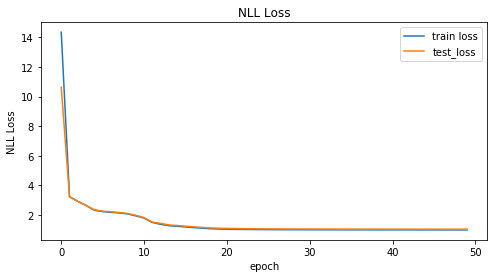

In [77]:
fig = plt.figure(figsize=(8, 4))
ax = sns.lineplot(np.arange(len(mdn_train_losses[:50])), mdn_train_losses[:50])
ax = sns.lineplot(np.arange(len(mdn_test_losses[:50])), mdn_test_losses[:50])
ax.set(xlabel='epoch', ylabel='NLL Loss')
plt.legend(['train loss', 'test_loss'])
plt.title('NLL Loss')
plt.show()

In [237]:
def most_prob_mu(pi, mu):
    n = pi.shape[0]
    _, max_component = torch.max(pi, 1)
    out = Variable(torch.zeros(n, OUT_DIM))
    for i in range(n):
        for j in range(OUT_DIM):
            out[i, j] = mu[i, max_component.data[i]*OUT_DIM+j]
    return out


def rand_sample_mu(pi, mu, sigmasq, samples=10):
    n = pi.shape[0]
    out = Variable(torch.zeros(n, samples, OUT_DIM))
    for i in range(n):
        for j in range(samples):
            u = np.random.uniform()
            prob_sum = 0
            for k in range(COEFS):
#                 print(pi.data[i])
#                 print(pi.data[i, k])
                prob_sum += pi.data[i, k]
                if u < prob_sum:
                    for od in range(OUT_DIM):
                        sample = np.random.normal(mu.data[i, k*OUT_DIM+od], np.sqrt(sigmasq.data[i, k]))
                        out[i, j, od] = sample
                    break
    return out

def first_n_most_prob_mu(pi, mu, sigma_sq, samples=10):
    n = pi.shape[0]
    out = Variable(torch.zeros(n, samples, OUT_DIM))
    for i in range(n):
#         print(pi.data[0])
#         print(mu.data[0])
#         print(sigma_sq.data[0])
        args = np.argsort(np.array(pi.data[i]))[::-1][:samples]
#         print(args)
#         most_sigma = np.take(sigma_sq.data[i], args)
#         print(most_sigma)
#         print(np.take(pi.data[i], args))
#         print(np.take(pi.data[i], args))
        for j in range(samples):
            for od in range(OUT_DIM):
#                 print(mu.data[i, args[j]*OUT_DIM+od])
#                 print(args[j]*OUT_DIM+od)
#                 print(mu.data[i, 17])
#                 print(sigma_sq.data[i, args[j]])
#                 print(mu.data[i, args[j]*OUT_DIM+od])
#                 print(sigma_sq.data[i, args[j]])
                sample = np.random.normal(mu.data[i, args[j]*OUT_DIM+od], np.sqrt(sigma_sq.data[i, args[j]]))
                out[i, j, od] = sample
#             a = np.array([np.array(pi.data[0]), np.array(sigma_sq.data[0])]).T
#             print(a)
#         return
#             print(a.view('f8,f8,f8'))
#             s = np.sort(a.view('f8,f8,f8'), order=['f1'], axis=0).view(np.float32)
#             print(s)
#             mp = np.sort(pi.data[0])[::-1][:samples]
#             print(mp)
#             return
#             u = np.random.uniform()
#             print(u)
#             prob_sum = 0
#             for k in range(COEFS):
# #                 print(pi.data[i])
# #                 print(pi.data[i, k])
#                 prob_sum += pi.data[i, k]
# #                 print(prob_sum)
#                 if u < prob_sum:
#           # sample from the kth component
#                     for od in range(OUT_DIM):
#                         sample = np.random.normal(mu.data[i, k*OUT_DIM+od], np.sqrt(sigmasq.data[i, k]))
#                         out[i, j, od] = sample
#                     break
#             return
    return out

In [241]:
pi, mu, sigma_sq = mdn_net(Variable(torch.from_numpy(x_test_inv)))
most_prob_mu_vals = most_prob_mu(pi, mu)
preds = rand_sample_mu(pi, mu, sigma_sq, samples=10)
fn_preds = first_n_most_prob_mu(pi, mu, sigma_sq, samples=10)

In [232]:
fn_preds

tensor([[[ -2.2534]],

        [[  8.8867]],

        [[ -6.0058]],

        ...,

        [[  9.2473]],

        [[  5.9421]],

        [[-14.5601]]])

In [233]:
most_prob_mu_vals

tensor([[ -2.2534],
        [  8.8867],
        [ -6.0058],
        ...,
        [  9.2473],
        [  5.9421],
        [-14.5601]], grad_fn=<CopySlices>)

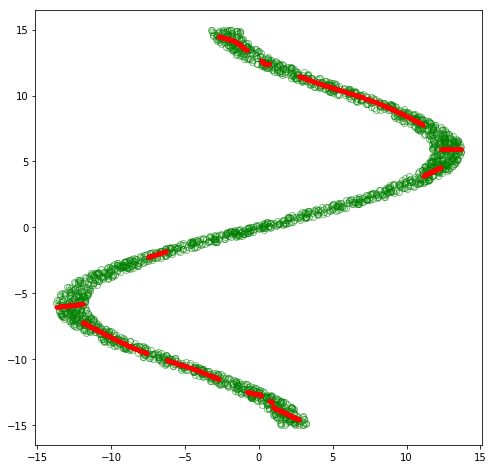

In [130]:
# plot the conditional mode at each point along x
fig = plt.figure(figsize=(8, 8))
plt.plot(x_test_inv, y_test_inv, 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test_inv, most_prob_mu_vals.data.numpy(), 'r.')
plt.show()

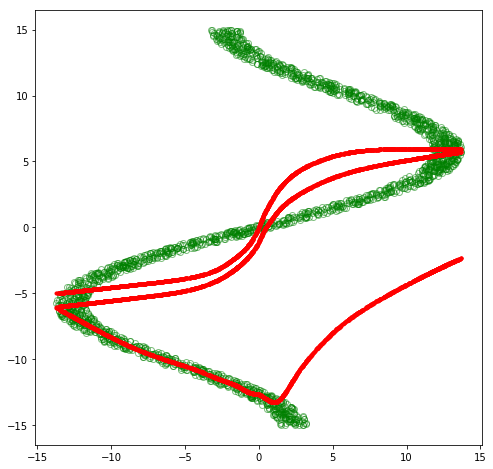

In [94]:
fig = plt.figure(figsize=(8, 8))
plt.plot(x_test_inv, y_test_inv, 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test_inv, mu.data.numpy()[:, :3], 'r.')
plt.show()

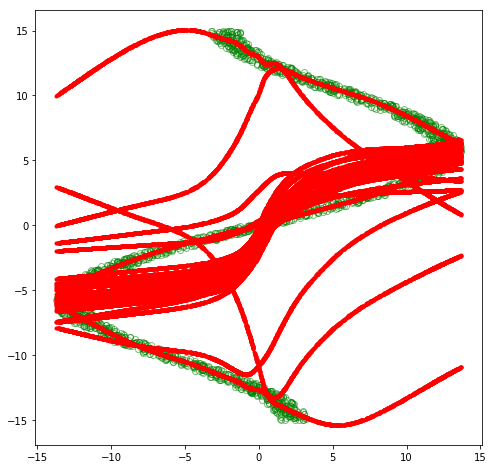

In [95]:
fig = plt.figure(figsize=(8, 8))
plt.plot(x_test_inv, y_test_inv, 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test_inv, mu.data.numpy(), 'r.')
plt.show()

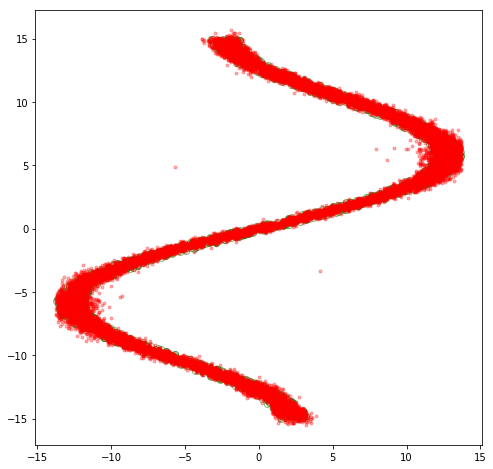

In [242]:
# plot sampled predictions at each point along x
fig = plt.figure(figsize=(8,8))
plt.plot(x_test_inv, y_test_inv, 'go', alpha=0.5, markerfacecolor='none')
for i in range(preds.shape[1]):
    plt.plot(x_test_inv, preds.data.numpy()[:, i], 'r.', alpha=0.3)
plt.show()

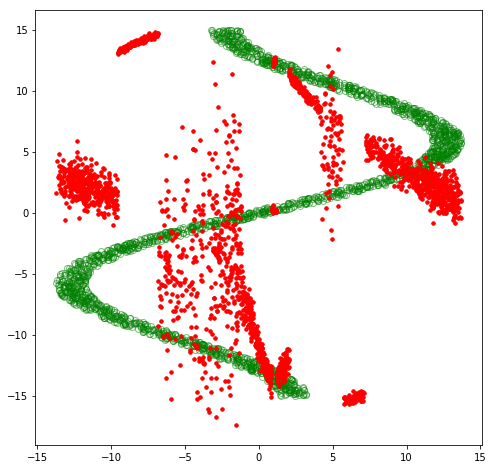

In [247]:
# plot sampled predictions at each point along x
fig = plt.figure(figsize=(8,8))
plt.plot(x_test_inv, y_test_inv, 'go', alpha=0.5, markerfacecolor='none')
for i in range(fn_preds.shape[1]):
    plt.plot(x_test_inv, fn_preds.data.numpy()[:, 3], 'r.', alpha=0.3)
plt.show()

In [21]:
# dimensionality of hidden layer
t = 1
d = 1
h = 50
n = 2250

k = 30  # 3

d_pi = k
d_sigmasq = k
d_mu = t * k

w1 = Variable(torch.randn(d, h) * np.sqrt(2/(d+h)), requires_grad=True)
b1 = Variable(torch.zeros(1, h), requires_grad=True)
w_pi = Variable(torch.randn(h, d_pi) * np.sqrt(2/(d+h)), requires_grad=True)
b_pi = Variable(torch.zeros(1, d_pi), requires_grad=True)
w_sigmasq = Variable(torch.randn(h, d_sigmasq) * np.sqrt(2/(d+h)), requires_grad=True)
b_sigmasq = Variable(torch.zeros(1, d_sigmasq), requires_grad=True)
w_mu = Variable(torch.randn(h, d_mu) * np.sqrt(2/(d+h)), requires_grad=True)
b_mu = Variable(torch.zeros(1, d_mu), requires_grad=True)


def forward(x):
    out = F.tanh(x.mm(w1) + b1)  # shape (n, h)
  #out = F.leaky_relu(x.mm(w1) + b1)  # interesting possibility
    pi = F.softmax(out.mm(w_pi) + b_pi, dim=1)  # p(z_k = 1) for all k; K mixing components that sum to 1; shape (n, k)
    sigmasq = torch.exp(out.mm(w_sigmasq) + b_sigmasq)  # K gaussian variances, which must be >= 0; shape (n, k)
    mu = out.mm(w_mu) + b_mu  # K * L gaussian means; shape (n, k*t)
    return pi, sigmasq, mu


def gaussian_pdf(x, mu, sigmasq):
  # NOTE: we could use the new `torch.distributions` package for this now
    return (1/torch.sqrt(2*np.pi*sigmasq)) * torch.exp((-1/(2*sigmasq)) * torch.norm((x-mu), 2, 1)**2)


def loss_fn(pi, sigmasq, mu, target):

    losses = Variable(torch.zeros(n)) # p(y|x)
    for i in range(k):  # marginalize over z
        likelihood_z_x = gaussian_pdf(target, mu[:, i*t:(i+1)*t], sigmasq[:, i])
        prior_z = pi[:, i]
        losses += prior_z * likelihood_z_x
    loss = torch.mean(-torch.log(losses))
    return loss

In [131]:
opt = optim.Adam([w1, b1, w_pi, b_pi, w_sigmasq, b_sigmasq, w_mu, b_mu], lr=0.008)

# wrap up the inverse data as Variables
x = Variable(torch.from_numpy(x_train_inv))
y = Variable(torch.from_numpy(y_train_inv))

for e in range(1000):
    opt.zero_grad()
    pi, sigmasq, mu = forward(x)
#     print(mu[0])
#     break
    loss = loss_fn(pi, sigmasq, mu, y)
    if e % 100 == 0:
        print(loss.data[0])
    loss.backward()
    opt.step()

tensor(14.4945)
tensor(2.2841)
tensor(1.8099)
tensor(1.6480)
tensor(1.2847)
tensor(1.1482)
tensor(1.0732)
tensor(1.0414)
tensor(1.0339)
tensor(1.0275)
